In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer 

Cannot import Surfe


## STEP 1 - Intrusion Network Definition

### (1) Construction of the GeoModel

In [2]:
# Loading the data

data = pd.read_csv('C:/Users/falv0002/Documents/Repositories/ODSIM/Intrusion_Network_Def/Example_1_Conformable_and_folded/Example_1_1Comformable_data.csv')
data['type'] = 'conformable'
# data.head()
# data['val'].unique()

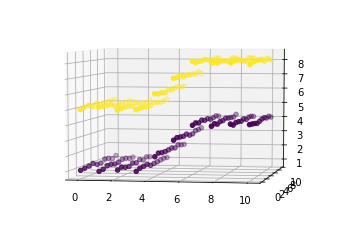

In [3]:
# Simple visualization of data points
fig1 = plt.figure()
ax1 = plt.axes(projection  = '3d')
ax1.scatter3D(data.iloc[:,1],data.iloc[:,2],data.iloc[:,3], c= data.iloc[:,4])
ax1.view_init(5, -80)

In [4]:
# Geo model construction using LoopStructural
lower_extent = np.array([0,0,0])
upper_extent = np.array([10,10,10])
geo_model = GeologicalModel(lower_extent,upper_extent)
geo_model.set_model_data(data)
conformable_feature = geo_model.create_and_add_foliation('conformable')

'type' is being replaced with 'feature_name' 




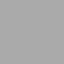

In [5]:
# Visualization of the Geologial model
viewer = LavaVuModelViewer(geo_model, background='white')
viewer.add_scalar_field(conformable_feature['feature'])
# viewer.add_isosurface(geo_model['conformable'], isovalue = 0)
viewer.rotate([-85,-5, 0])
viewer.add_data(conformable_feature['feature'])

# viewer.display()
viewer.interactive()

### (2) Parametrization of the Geological Model
#### 2.1 Given a set of contact data points, identify different contacts between the intrusion and any other geological unit

In this examples, there are points in both contacts, so we need to find which points represent which contact
This is done by finding clusters of points with different scalar field value

In [6]:
# Load the observation points
contact_points_df = pd.read_csv('C:/Users/falv0002/Documents/Repositories/ODSIM/Intrusion_Network_Def/Example_1_Conformable_and_folded/Example_1_2Observations.csv')
contact_points_df.head()
number_points = len(contact_points_df)

# Create array with (x,y,z) coords
contact_points = np.zeros([number_points,4]) #columns: x, y ,z, scalar field value, cluster_label


for i in range(number_points):
    contact_points[i,0] = contact_points_df.loc[i,'X']
for i in range(number_points):
    contact_points[i,1] = contact_points_df.loc[i,'Y']
for i in range(number_points):
    contact_points[i,2] = contact_points_df.loc[i,'Z']


# Evaluate points in the geological model, to obtain scalar field of each contact point
scalar_field_vals = conformable_feature['feature'].evaluate_value(geo_model.scale(np.array([contact_points[:,0],contact_points[:,1],contact_points[:,2]]).T))

contact_points_df['Values'] = 0
n=0
for j in range(len(scalar_field_vals)):
    contact_points_df.loc[j,'Values'] = scalar_field_vals[j]
    contact_points[j,3] = scalar_field_vals[j]
    

(0.0, 10.0)

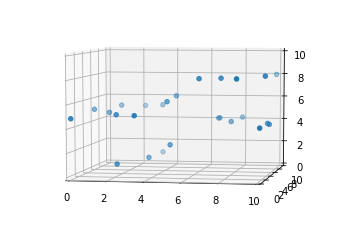

In [7]:
# Simple visualization of observation points
fig = plt.figure()
ax = plt.axes(projection  = '3d')
ax.scatter3D(contact_points[:,0],contact_points[:,1],contact_points[:,2])
ax.view_init(6,-80)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0,10)

In [8]:
#Function to find clusters

def contact_clustering(contact_array):
    from sklearn.cluster import DBSCAN
    #for a given array such (x,y,z,scalar field val), 
    #returns a list of arrays, each array with a group of contact points belonging to the same contact
    
    n_points = len(contact_array)
    sf_vector = np.zeros([n_points,2]) # matrix containing scalar field values as (0,value)
    for m in range(n_points):
        sf_vector[m] = [ 0, contact_array[m, 3]]
    
    #eps refers to the max distance that a sample can be from a core sample to be part of the cluster
    #here is calculates as the mean of the distances between every point
    distances = np.zeros(n_points*n_points)
    l = 0
    for h in range(n_points):
        for u in range(n_points):
            distances[l] = abs(contact_array[h,3]-contact_array[u,3])
            l = l+1                    
    eps = np.mean(distances)

    #Clustering using DBSCAN algorithm
    clustering = DBSCAN(eps, min_samples=1).fit(sf_vector)
    labels=clustering.labels_
    
    #grouping the points in different arrays
    clusters = np.unique(labels)
    n_clusters = len(clusters)
    contacts = []
    
    for o in range(n_clusters):
        count = 0
        for e in range(n_points):
            if labels[e] == clusters[o]:
                count = count +1
        contact_temp = np.zeros([count,5])
        d = 0 
        for f in range(n_points):
            if labels[f] == clusters[o]:
                contact_temp[d,:4] = contact_array[f]
                contact_temp[d,4] = clusters[o]
                d=d+1
        contacts.append(contact_temp)  
        
    return contacts    
        

In [9]:
contacts_list = contact_clustering(contact_points)
c0 = contacts_list[0]
c1 = contacts_list[1]
# print(c0)
# print(np.around(c1,2))

In [10]:
# Evaluate points in the geological model, to obtain the scalar field gradient of each contact point
scalar_field_grads = conformable_feature['feature'].evaluate_gradient(geo_model.scale(np.array([c0[:,0],c0[:,1],c0[:,2]]).T))
obs_points_grads = np.hstack([c0[:,:4],scalar_field_grads])

# Create a data frame with the coordinates points, gradient of the scalar field 
grads_df = pd.DataFrame(obs_points_grads, columns = ['X','Y','Z','val','nx','ny','nz'])
grads_df.to_csv('c:/Users/falv0002/Documents/Repositories/ODSIM/Intrusion_Network_Def/Example_1_Conformable_and_folded/Example_1_4SFGradientsPoints.csv')

(0.0, 10.0)

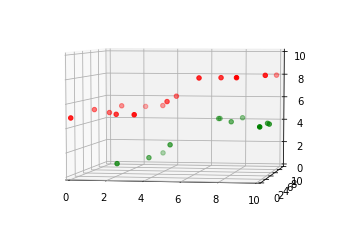

In [11]:
# Simple visualization of grouped observation points 
fig = plt.figure()
ax = plt.axes(projection  = '3d')
ax.scatter3D(c0[:,0],c0[:,1],c0[:,2],c='red')
ax.scatter3D(c1[:,0],c1[:,1],c1[:,2],c='green')
ax.view_init(5,-80)
ax.set_xlim(0,10) ; ax.set_ylim(0,10) ; ax.set_zlim(0,10)

Indicator function of the geological model, assuming 3 units, and 2 contacts: 
- Unit G0 --> scalar field < 0
- Unit G1 --> 0 <= scalar field <= 1
- Unit G2 --> scalar field > 1
- Contact C0 --> scalar field around 0
- Contact C1 --> scalar field around 1

In [12]:
#creation of the grid 

spacing = 100
x = np.linspace(lower_extent[0],upper_extent[0],spacing)
y = np.linspace(lower_extent[1],upper_extent[0],spacing)
z = np.linspace(lower_extent[2],upper_extent[0],spacing)

# Evaluation of all the points of the grid in the different scalar fields. In this case, only one scalar  field (conformable)
xx,yy,zz = np.meshgrid(x,y,z)
grid_points = np.array([xx.flatten(),yy.flatten(),zz.flatten()]).T
conformable_values = conformable_feature['feature'].evaluate_value(geo_model.scale(grid_points, inplace = False))


In [13]:
n_grid_points = len(grid_points)
Ig = np.zeros([n_grid_points,3]) #Indicator matrix of geological units
for k in range(n_grid_points):
    if conformable_values[k] < 0:
        Ig[k,0] = 1
    elif conformable_values[k] > 1:
        Ig[k,2] = 1
    else:
        Ig[k,1] = 1

In [14]:
Ic = np.zeros([n_grid_points,1]) #Indicator matrix of contacts of interest
# Ic_ = np.zeros([n_grid_points,1])
# for each set of observation points (in this case c0 and c1) calculate mean and std dev of scalar fields
# then, considers as contact points all x=(x,y,z) with scalar field e [mean-std dev, mean+std dev]
c0_mean_ = np.mean(c0, axis = 0)
c0_mean = c0_mean_[3]
c0_std_ = np.std(c0, axis = 0)
c0_std = c0_std_[3]

c1_mean_ = np.mean(c1, axis = 0)
c1_mean = c1_mean_[3]
c1_std_ = np.std(c1, axis = 0)
c1_std = c1_std_[3]

for s in range(n_grid_points):
    if conformable_values[s] <= c0_mean+c0_std and conformable_values[s] >= c0_mean-c0_std:
        Ic[s] = 1
#         Ic_[s] = 1
#     elif conformable_values[s] <= c1_mean+c1_std and conformable_values[s] >= c1_mean-c1_std:
#         Ic[s,1] = 1
#         Ic_[s] = 1
c0_mean        

0.9893049442770007

### (3) Construction of the Network
#### 3.1. Simulation of the medium

In [15]:
#Velocity field
Kc = np.array([10]) #velocities for each contact, in this case K(c0)=K(c1)=10
Kg = [0.1, 0.1, 0.1] #velocities for each geological unit, in this case K(g0)=K(g1)=K(g2)=0.1

kc = np.dot(Ic,Kc)
kc_ = (1-Ic).flatten()
kg = np.dot(Ig,Kg)
velocity_field_step1 = kc + (kc_*kg)

In [16]:
medium = np.zeros([n_grid_points,5])
medium[:,:3] = grid_points
medium[:,3] = conformable_values
medium[:,4] = velocity_field_step1

In [17]:
# Create a data frame with the coordinates points, values of the scalar field related to all geo features, and velocity of the medium for step 1
medium_df = pd.DataFrame(medium, columns = ['X','Y','Z','val','k_step1'])
medium_df.sort_values(['Y','X','Z'], ascending = [False, True, False], inplace = True)
# distance.to_csv('c:/Users/falv0002/Documents/Repositories/ODSIM/Intrusion_Network_Def/Example_1_Conformable_and_folded/Example_1_4Distance.csv')

In [18]:
#creation of sections

ys_values = medium_df['Y'].unique()
medium_list = []
for y in range(len(ys_values)):
    
    section = np.zeros([spacing**2,5])
    l = 0
        
    for i in range(pow(spacing,3)):
        if medium_df.loc[i , 'Y'] == ys_values[y]:
            section[l,0] = medium_df.loc[i , 'X']
            section[l,1] = medium_df.loc[i , 'Y']
            section[l,2] = medium_df.loc[i , 'Z']
            section[l,3] = medium_df.loc[i , 'val']
            section[l,4] = medium_df.loc[i , 'k_step1']
            l=l+1
    medium_list.append(section)        

In [19]:
#grid - array

def grid_from_array(array, fixed_coord, lower_extent, upper_extent): 
    # to a specific array, this function assigns coordinates for each array element of index [i,j].
    # returns a matrix of [i,j,x,y,z,values in array]
    # fixed_coord --> array of 1x2 with coordinate fixed and value, 
    # ie, [0,2] means section is in x=2, or [1, .45] means sections is in y= 0.45
    
    spacing_i = len(array) # number of rows
    spacing_j = len(array[0]) #number of columns
    values = np.zeros([spacing_i*spacing_j,6])
    if fixed_coord[0] == 0:
        y = np.linspace(lower_extent[1],upper_extent[1],spacing_j)
        z = np.linspace(lower_extent[2],upper_extent[2],spacing_i)
        l = 0
        for j in range(spacing_j):
            for i in range(spacing_i):
                values[l] = [i, j, fixed_coord[1], y[j], z[i], array[spacing_i-1-i,j]]
                l=l+1
                
    if fixed_coord[0] == 1:
        x = np.linspace(lower_extent[0],upper_extent[0],spacing_j)
        z = np.linspace(lower_extent[2],upper_extent[2],spacing_i)
        l = 0
        for j in range(spacing_j):
            for i in range(spacing_i):
                values[l] = [i, j, x[j], fixed_coord[1], z[i], array[spacing_i-1-i,j]]
                l=l+1
                
    if fixed_coord[0] == 2:
        x = np.linspace(lower_extent[0],upper_extent[0],spacing_j)
        y = np.linspace(lower_extent[1],upper_extent[1],spacing_i)
        l = 0
        for j in range(spacing_j):
            for i in range(spacing_i):
                values[l] = [spacing_i-1-i, spacing_j-1-j, x[j], y[i], fixed_coord[1], array[spacing_i-1-i,j]]
                l=l+1
                
    return values

def grid_from_array_nodes(array, array_nodes,fixed_coord, lower_extent, upper_extent): 
    # to a specific array, this function assigns coordinates for each array element of index [i,j].
    # returns a matrix of [i,j,x,y,z,values in array]
    # fixed_coord --> array of 1x2 with coordinate fixed and value, 
    # ie, [0,2] means section is in x=2, or [1, .45] means sections is in y= 0.45
    
    spacing_i = len(array) # number of rows
    spacing_j = len(array[0]) #number of columns
    values = np.zeros([spacing_i*spacing_j,7])
    if fixed_coord[0] == 0:
        y = np.linspace(lower_extent[1],upper_extent[1],spacing_j)
        z = np.linspace(lower_extent[2],upper_extent[2],spacing_i)
        l = 0
        for j in range(spacing_j):
            for i in range(spacing_i):
                values[l] = [array_nodes[i,j], i, j, fixed_coord[1], y[j], z[i], array[spacing_i-1-i,j]]
                l=l+1
                
    if fixed_coord[0] == 1:
        x = np.linspace(lower_extent[0],upper_extent[0],spacing_j)
        z = np.linspace(lower_extent[2],upper_extent[2],spacing_i)
        l = 0
        for j in range(spacing_j):
            for i in range(spacing_i):
                values[l] = [array_nodes[i,j], i, j, x[j], fixed_coord[1], z[i], array[spacing_i-1-i,j]]
                l=l+1
                
    if fixed_coord[0] == 2:
        x = np.linspace(lower_extent[0],upper_extent[0],spacing_j)
        y = np.linspace(lower_extent[1],upper_extent[1],spacing_i)
        l = 0
        for j in range(spacing_j):
            for i in range(spacing_i):
                values[l] = [array_nodes[i,j], spacing_i-1-i, spacing_j-1-j, x[j], y[i], fixed_coord[1], array[spacing_i-1-i,j]]
                l=l+1
                
    return values


def array_from_coords(df, axis):
    #for a given dataframe with coordinates and value, create an array of the value data
    # n refers to the column where the data is 
    col = len(df.columns)
    if col < axis:
        return 'axis out of range'
    else:
        df.sort_values(['X','Z'], ascending = [True, False], inplace = True)
        xs = df['X'].unique()
        zs = df['Z'].unique()
        rows = len(zs)
        columns = len(xs)
        array = np.zeros([rows,columns])
        n= 0
        for j in range(columns):
            for i in range(rows):
                array[i,j] = df.iloc[i+n,axis]
            n = n+rows
        return array

def array_from_coords_nodes(df, axis):
    #for a given dataframe with coordinates and value, create an array of the nodes ID
    
    col = len(df.columns)
    if col < axis:
        return 'axis out of range'
    else:
        df.sort_values(['X','Z'], ascending = [True, False], inplace = True)
        xs = df['X'].unique()
        zs = df['Z'].unique()
        rows = len(zs)
        columns = len(xs)
        array = np.zeros([rows,columns])
        n= 0
        for j in range(columns):
            for i in range(rows):
                array[i,j] = df.iloc[i+n,axis]
            n = n+rows
        return array    

# Shortest Path Functions

def element_neighbour(index, array, inet): #return an array 1x5 with the values of the neighbours of a particular element
    # parameters: 'index' --> array 1x2 with indexes of point of interes [row, col]. 
    # parameters: 'array' --> array with values of interest  
    # parameters: 'inet' --> array of current intrusion network. If one of the elements is already inet=0, the assign -1.
    
    rows = len(array)-1 # max index of rows of time_map array 
    cols = len(array[0])-1 # max index of columns of time_map arrays
    values = np.zeros(9) # array to save the values (element above, element to the left, element to the right)
    values[8] = 10
    index_row = index[0]
    index_col = index[1]
    
    if index_row == 0:
        values[0]=-1
        values[1]=-1
        values[2]=-1
    
    if index_row == rows:
        values[5]=-1
        values[6]=-1
        values[7]=-1

    if index_col == 0:
        values[0]=-1
        values[3]=-1
        values[5]=-1
    
    if index_col == cols:
        values[2]=-1
        values[4]=-1
        values[7]=-1
        
    for k in range(8):
        if values[k] > -1:
            if k == 0:          
                values[0] = array[index[0]-1, index[1]-1]

            if k == 1:  
                values[1] = array[index[0]-1, index[1]]
            
            if k == 2:
                values[2] = array[index[0]-1, index[1]+1]
            
            if k == 3:
                values[3] = array[index[0], index[1]-1]
                
            if k == 4:
                values[4] = array[index[0], index[1]+1]

            if k == 5:
                values[5] = array[index[0]+1, index[1]-1]

            if k == 6:
                values[6] = array[index[0]+1, index[1]]

            if k == 7:
                values[7] = array[index[0]+1, index[1]+1]
        
        else:
            continue
      
    #check if some of the neighbours is already part of the intrusion network
    for h in range(8):
        if values[h] > -1:
            if h == 0:          
                if inet[index[0]-1, index[1]-1] == 0:
                    values[0] = -1
            if h == 1:  
                if inet[index[0]-1, index[1]] == 0:
                    values[1] = -1
            if h == 2:  
                if inet[index[0]-1, index[1]+1] == 0:
                    values[2] = -1
            if h == 3:  
                if inet[index[0], index[1]-1] == 0:
                    values[3] = -1
            if h == 4:  
                if inet[index[0], index[1]+1] == 0:
                    values[4] = -1
            if h == 5:  
                if inet[index[0]+1, index[1]-1] == 0:
                    values[5] = -1
            if h == 6:  
                if inet[index[0]+1, index[1]] == 0:
                    values[6] = -1
            if h == 7:  
                if inet[index[0]+1, index[1]+1] == 0:
                    values[7] = -1
        else:
            continue

        
    return values

def index_min(array): #return the index value of the minimum value in an array of 1x8
    index_array = {}
    
    for i in range(8): #create a dictionary assining positions from 0 to 7 to the values in the array
        a=i
        if array[i]>=0:
            index_array.update({i:array[i]})
    
    minimum_val = min(index_array.values())
    
    for key, value in index_array.items():
        if value == minimum_val:
            index_min = key 

    return index_min

def new_inlet(inlet,direction): 
    #outlet is an array of the outlet position
    #direction in a number--> 0: above-left, 1: above, 2: above right, 3: left, 4: right, 5: below left, 6: below, 7:below right
    pot_new_inlets = {}
    
    pot_new_inlets.update({"0": np.array([inlet[0]-1, inlet[1]-1])})
    pot_new_inlets.update({"1": np.array([inlet[0]-1, inlet[1]])})
    pot_new_inlets.update({"2": np.array([inlet[0]-1, inlet[1]+1])})
    pot_new_inlets.update({"3": np.array([inlet[0], inlet[1]-1])})
    pot_new_inlets.update({"4": np.array([inlet[0], inlet[1]+1])})
    pot_new_inlets.update({"5": np.array([inlet[0]+1, inlet[1]-1])})
    pot_new_inlets.update({"6": np.array([inlet[0]+1, inlet[1]])})
    pot_new_inlets.update({"7": np.array([inlet[0]+1, inlet[1]+1])})
    new_outlet = np.zeros(2)
    
    for key, value in pot_new_inlets.items():
        if key == str(direction):
            new_inlet = value
    return new_inlet
            
def shortest_path(inlet, outlet, time_map):
    # Look for the shortest path between inlet and outlet. returns a matrix with 0's showing the intrusion network (shortest path). 
    # parameters: 'inlet' and 'oulet' --> array of indexes of inlet and outlet of the system
    # parameters: 'time_map' --> array with time map
    # returns an array with 0s showing the intrusion network, 1s above it, and -1s below it
    
    inet= np.ones_like(time_map) #array to save shortest path with zeros
    temp_inlet = inlet
    inet[temp_inlet[0],temp_inlet[1]] = 0
    i=0
    
    while True:
        i=i+1
        time_temp_inlet = time_map[temp_inlet[0], temp_inlet[1]] # obtain time value of temporary outlet
        neighbors = element_neighbour(temp_inlet, time_map, inet) # identify neighbours elements of temporary outlet
        direction = index_min(neighbors) #obtain the location (index min) of minimun difference
        temp_inlet = new_inlet(temp_inlet, direction)
        a = temp_inlet[0]
        b = temp_inlet[1]
        inet[a,b] = 0
        
        if temp_inlet[0]==outlet[0] and temp_inlet[1]==outlet[1]:
            break
        else:
            continue
                 
    for j in range(len(inet[0])): #columns
        for h in range(len(inet)): #rows
            if inet[h,j] == 0:
                index = h
                break
                
        for g in range(len(inet)):
            if g > h:
                inet[g,j] = -1
            else:
                continue
            
    return inet

def velocity_field(distance_field):
    #for an array containing the distance field of a section, Create array with values and velocity as v = 1/d^2
    velocity = np.zeros(distance_field.shape)
    rows = len(distance_field) 
    cols = len(distance_field[0])
    
    for i in range(cols):
        for j in range(rows):
            if distance_field[j,i] != 0:
                velocity[j,i] = 1/(distance_field[j,i]**2)
            else:
                velocity[j,i] = 50
    return velocity

def inlet(scalar_field_array, val):
#Identify the inlet of a section. 
#In this case, the inlet is the node of the first column with a the most similar scalar value to contact of interests.    
    rows = len(scalar_field_array)
    diff = np.zeros([rows,1])
    for i in range(rows):
        diff[i] = abs(scalar_field_array[i,0]-val)
        
    inlet_value = np.min(diff) 
    
    for i in range(rows):
        if diff[i] == inlet_value:
            inlet_index_section1 = i
            
    inlet = np.array([inlet_index_section1,0])
    return inlet
    
def outlet(scalar_field_array, val):
#Identify the outlet of a section. 
#In this case, the outlet is the node of the last column with a the most similar scalar value to contact of interests.        
    
    cols = len(scalar_field_array[0])
    rows = len(scalar_field_array)
    diff = np.zeros([rows,1])
    for i in range(rows):
        diff[i] = abs(scalar_field_array[i,cols-1]-val)
        
    outlet_value = np.min(diff)
    
    for i in range(rows):
        if diff[i] == outlet_value:
            outlet_index_section1 = i
    
    outlet = np.array([outlet_index_section1,cols-1])
    return outlet

In [20]:
conformable_sf_arrays = []
velocity_arrays_step1 = []
initial_point_array = [] #list having arrays with the initial points (outlet) to compute the time map of each section
inlet_array = []
outlet_array = []

for h in range(len(medium_list)):
# for h in range(2):
    df_temp = pd.DataFrame(medium_list[h],columns = ['X','Y','Z','val','k'])
    df_temp.sort_values(['X','Z'], ascending = [True, False], inplace = True)
    
    #create list of arrays with conformable values
    conform_temp = array_from_coords(df_temp,3)
    conformable_sf_arrays.append(conform_temp)
    
    #create list of arrays with velocities values
    velocity = array_from_coords(df_temp,4)
    velocity_arrays_step1.append(velocity)
    
    #inlet and outlet identification
    inlet_temp = inlet(conform_temp, 1)
    outlet_temp = outlet(conform_temp, 1)
    inlet_array.append(inlet_temp)
    outlet_array.append(outlet_temp)
    array = np.ones([spacing,spacing])
    array[outlet_temp[0],outlet_temp[1]] = 0
    initial_point_array.append(array)       

In [21]:
# # Visualization of velocities on each sections

# fig = plt.figure()
# fig, ax = plt.subplots(5,10, figsize = (20,20),)
# d = 0
# for g in range(10):
#     for h in range(5):
#         vel_temp = velocity_arrays_step1[d]
#         d = d+1
#         ax[h,g].imshow(vel_temp)

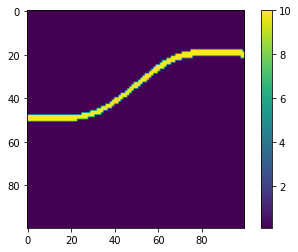

In [22]:
plt.imshow(velocity_arrays_step1[0])
plt.colorbar(cmap=np.linspace(np.min(velocity_arrays_step1[0]),np.max(velocity_arrays_step1[0])))
plt.savefig('Velocity_Field_colorbar.tiff')

In [23]:
# Create 3D model of velocity field and visualization

velocity_step1_coords = grid_from_array(velocity_arrays_step1[0],[1,ys_values[0]],lower_extent,upper_extent)

for h in range(len(velocity_arrays_step1)-1):
# for h in range(1):
    h=h+1
    temp_vel_coords = grid_from_array(velocity_arrays_step1[h],[1,ys_values[h]],lower_extent,upper_extent)
    velocity_step1_coords = np.vstack([velocity_step1_coords,temp_vel_coords])


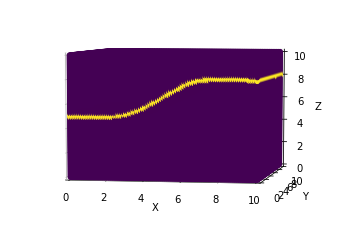

In [24]:
# 3D Visualization of the velocity field
ax = plt.axes(projection='3d')
ax.scatter3D(velocity_step1_coords[:,2],velocity_step1_coords[:,3],velocity_step1_coords[:,4], c = velocity_step1_coords[:,5])
ax.view_init(5, -80)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0,10)
# plt.legend()
plt.savefig('Velocity_field.tiff')

#### 3.3 Time Map

In [25]:
# Compute of time map, starting from the outlet, and given the velocity field defined above.
import skfmm as fmm

time_map_array = [] #list having arrays with time map of each section
for o in range(len(velocity_arrays_step1)):
    time_map_section = fmm.travel_time(initial_point_array[o], velocity_arrays_step1[o], order = 1)
    time_map_array.append(time_map_section)

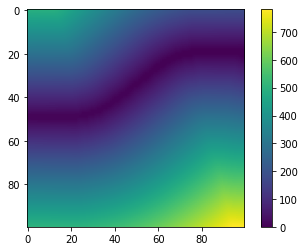

In [26]:
plt.imshow(time_map_array[0])
plt.colorbar(cmap=np.linspace(np.min(time_map_array[0]),np.max(time_map_array[0])))
plt.savefig('Time_Map_colorbar.tiff')

In [27]:
# # Visualization of time maps

# fig = plt.figure()
# fig, ax = plt.subplots(5,10, figsize = (20,20))
# d = 0
# for g in range(10):
#     for h in range(5):
#         time_map_temp = time_map_array[d]
#         d = d+1
#         ax[h,g].imshow(time_map_temp)
#         ax[h,g].contour(time_map_temp,levels=[1,5,10,20,30,40,50],colors=['red','pink','orange','yellow'])

In [28]:
# Create 3D model of time map and visualization

time_map_coords = grid_from_array(time_map_array[0],[1,ys_values[0]],lower_extent,upper_extent)

for h in range(len(time_map_array)-1):
# for h in range(1):
    h=h+1
    temp_timemap_coords = grid_from_array(time_map_array[h],[1,ys_values[h]],lower_extent,upper_extent)
    time_map_coords = np.vstack([time_map_coords,temp_timemap_coords])

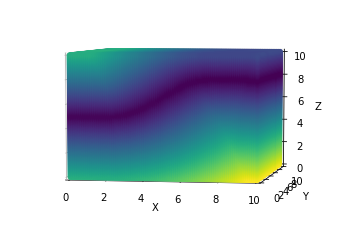

In [29]:
# 3D Visualization of the time map
ax = plt.axes(projection='3d')
ax.scatter3D(time_map_coords[:,2],time_map_coords[:,3],time_map_coords[:,4], c = time_map_coords[:,5])
ax.view_init(5, -80)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0,10)
# plt.legend()
plt.savefig('Time_Map.tiff')

#### 3.4 Shortest Path and Intrusion Network Definition

In [30]:
# Find shortest path, starting from the inlet
# Compute the coordinates for the intrusion network and save the points

inet_array = [] #list having arrays with shortest path (0 value shows shortest path)
inet_coords = [] #list having arrays with coordinates of intrusion network
for s in range(len(time_map_array)):
    intrusion_network_section = shortest_path(inlet_array[s], outlet_array[s], time_map_array[s])
    inet_array.append(intrusion_network_section)
    intrusion_network_coords_section = grid_from_array(intrusion_network_section, [1,ys_values[s]] , lower_extent, upper_extent)
    inet_coords.append(intrusion_network_coords_section)

In [31]:
# # Visualization of the shortest path on each section
# fig = plt.figure()
# fig, ax = plt.subplots(5,10, figsize = (20,20))
# d = 0
# for g in range(5):
#     for h in range(10):
#         shortestpath_temp = inet_array[d]
#         ax[g,h].imshow(shortestpath_temp)
#         d = d+1

In [32]:
# Create 3D model of the intrusion network and visualization
# Also, identify to which feature is related the intrusion network segment (in this case contact c0 or fault f0)

# Create array of all coordinates of the intrusion network
inet_coords_temp = inet_coords[0]
for g in range(len(inet_coords)-1):
    inet_coords_temp = np.vstack([inet_coords_temp, inet_coords[g+1]])
    
counta = sum(1 for i in range(len(inet_coords_temp)) if inet_coords_temp[i,5] == 0)

inet_coordinates = np.zeros([counta, 4])
kl = 0
for df in range(len(inet_coords_temp)):
    if inet_coords_temp[df,5] == 0:
        inet_coordinates[kl,0] = inet_coords_temp[df,2] #X coordinate
        inet_coordinates[kl,1] = inet_coords_temp[df,3] #Y coordinate
        inet_coordinates[kl,2] = inet_coords_temp[df,4] #Z coordinate
        inet_coordinates[kl,3] = inet_coords_temp[df,5] #intrusion network value, must be 0 
        kl=kl+1
        

In [33]:
len(inet_coordinates)

10000

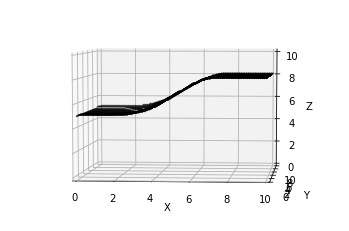

In [34]:
ax = plt.axes(projection='3d')
ax.scatter3D(inet_coordinates[:,0],inet_coordinates[:,1],inet_coordinates[:,2], c = 'black', s=0.05)
# ax.scatter3D(c1[:,0],c1[:,1],c1[:,2], c = ['blue', 'blue', 'red', 'red', 'red', 'blue', 'red', 'blue', 'green','blue','blue' ], s=5)
ax.view_init(5, -85)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0,10)
plt.savefig('Shortest_Path.tiff')


In [35]:
Intrusion_Network_Coordinates = pd.DataFrame(inet_coordinates, columns = ['X','Y','Z','val'])
Intrusion_Network_Coordinates.to_csv('c:/Users/falv0002/Documents/Repositories/ODSIM/Intrusion_Network_Def/Example_1_Conformable_and_folded/Example_1_4InetCoordinates.csv')

## STEP 2 - Coarse-Scale Geometry of the Intrusion

A distance field is going to be used compute the scalar field around the intrusion network. 
The thickness of the intrusion is given by the distance between the intrusion network and the contact points of the other contacts. In this case we built the intrusion network using the roof contact points, so we have to build the envelope volume using the floor contact points

In [51]:
def min_distance_point_inet(point, intrusion_net_coords):
    import math
    #point --> array of 1x3 like (px,py,pz)
    #inet_coords --> array of points of the intrusion network, like (node, x,y,z, +other values)
    px = point[0]
    py = point[1]
    pz = point[2] 
    distances = np.zeros([len(intrusion_net_coords),1])
    for i in range(len(intrusion_net_coords)):
        ix = intrusion_net_coords[i,0]
        iy = intrusion_net_coords[i,1]
        iz = intrusion_net_coords[i,2]
        distances[i] = math.sqrt(pow((px-ix),2)+pow((py-iy),2)+pow((pz-iz),2))
        
    minimum_distance = min(distances)

    
    return minimum_distance

def distance_point_line_xz(line_pointA, line_pointB, point):
    import math
    m = (line_pointB[2]-line_pointA[2])/(line_pointB[0]-line_pointA[0])
    b = line_pointA[2] - (line_pointA[0]*m)
    
    distance = abs((m*point[0] - point[2] + b)/math.sqrt(pow(m,2)+1))
    
    return distance
    

#### 1.1 Definition of thickness, consdering data points of the other contact (in this case, the roof contact)

In [52]:
floor_points = c1[:,:4]
floor_points_mean = np.mean(floor_points, axis = 0)
thickness_values = np.zeros([len(floor_points)])
for i in range(len(floor_points)):
    thickness_values[i] = min_distance_point_inet(floor_points[i], inet_coordinates)
thickness_mean = np.mean(thickness_values)

In [53]:
# create list of arrays with euclidean distances for the step 2

distance_arrays_step2 = []
distances_coords = []
max_distance_ref_points = -thickness_mean

for h in range(len(medium_list)):
# for h in range(1):
    inet_temp = inet_array[h]
    dist_temp = fmm.distance(inet_temp, dx=(10/spacing))
    distance_arrays_step2.append(dist_temp)
    distances_coords_section = grid_from_array(dist_temp, [1,ys_values[h]] , lower_extent, upper_extent)
    distances_coords.append(distances_coords_section)

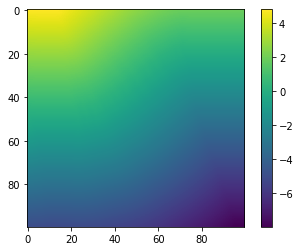

In [54]:
plt.imshow(distance_arrays_step2[0])
plt.colorbar(cmap=np.linspace(np.min(distance_arrays_step2[0]),np.max(distance_arrays_step2[0])))


In [55]:
# Create 3D model of the intrusion and visualization

# Create array of all coordinates of the intrusion body
dist_coords_temp = distances_coords[0]
for gf in range(len(distances_coords)-1):
    dist_coords_temp = np.vstack([dist_coords_temp, distances_coords[gf+1]])
    
counta = sum(1 for i in range(len(dist_coords_temp)) if dist_coords_temp[i,5] <= 0 and dist_coords_temp[i,5]>= max_distance_ref_points)

distance_coordinates = np.zeros([counta, 5])
l = 0
for i in range(len(dist_coords_temp)):
    if dist_coords_temp[i,5] <= 0 and dist_coords_temp[i,5] >= max_distance_ref_points:
        distance_coordinates[l,0] = dist_coords_temp[i,2] #X coordinate
        distance_coordinates[l,1] = dist_coords_temp[i,3] #Y coordinate
        distance_coordinates[l,2] = dist_coords_temp[i,4] #Z coordinate
        distance_coordinates[l,3] = dist_coords_temp[i,5] #distance value 
        l=l+1

In [56]:
# inet_coordinates
# ax = plt.axes(projection='3d')
# ax.scatter3D(distances_coords[0][:,2],distances_coords[0][:,3],distances_coords[0][:,4], c=distances_coords[0][:,5], s=0.01)
# ax.view_init(0, -90)

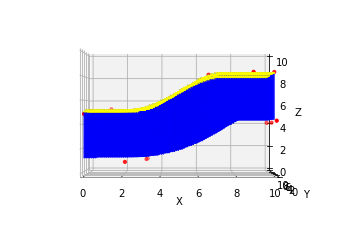

In [63]:
inet_coordinates
ax = plt.axes(projection='3d')
ax.scatter3D(distance_coordinates[:,0],distance_coordinates[:,1],distance_coordinates[:,2], c='blue', s=0.01)
ax.scatter3D(inet_coordinates[:,0],inet_coordinates[:,1],inet_coordinates[:,2], c = 'yellow', s=0.05)
ax.scatter3D(c0[:,0],c0[:,1],c0[:,2],c='red', s=10)
ax.scatter3D(c1[:,0],c1[:,1],c1[:,2],c='red', s=10)
ax.view_init(0, -90)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0,10)
plt.savefig('Step2.tiff')